In [2]:
import numpy as np
import matplotlib.pylab as plt
import random
import copy
import pandas
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import *
import torchvision
import pickle
from tqdm import *

Load Data
======

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
X = []
Y = []

for b in range(1, 6):
    D = unpickle('./cifar-10-batches-py/data_batch_%s' % b)
    X.append( D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8') )
    Y.append( np.array(D[b'labels']))
    names = [x.decode('utf-8') for x in D]

X = np.vstack(X)
Y = np.hstack(Y).astype('int')

D = unpickle('./cifar-10-batches-py/test_batch')
Xt = D[b'data'].reshape((-1, 3, 32, 32)).astype('uint8')
Yt = np.array(D[b'labels']).astype('int')
Lt = D[b'filenames']

Augmentation
===

In [5]:
to_img = ToPILImage()
resized_crop = RandomResizedCrop(32)
crop = RandomCrop([32,32])
central_crop = CenterCrop([32,32])
flip = RandomHorizontalFlip()
color = ColorJitter(brightness=0.5,contrast=0,saturation=0)
gray = Grayscale()
to_tensor = ToTensor()

In [6]:
x = X[0]
x = torch.from_numpy(x)
x = to_tensor(to_img(x)).numpy()
v = torch.from_numpy(x)
v = color(to_img(v))
v = to_tensor(v).numpy()
v.shape

(3, 32, 32)

Show image
===

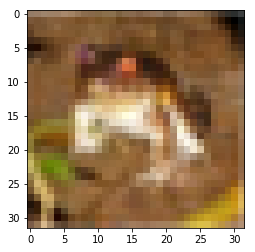

In [7]:
plt.imshow(np.rot90(x.T, k=3))

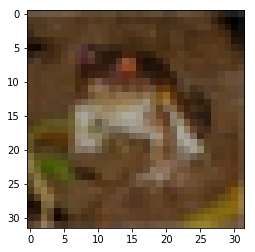

In [8]:
plt.imshow(np.rot90(v.T, k=3))

In [8]:
%%time

Xa = []
Ya = []

for i in range(X.shape[0]):
    x = X[i]
    x = torch.from_numpy(x)
    x = to_tensor(to_img(x)).numpy()
    v = torch.from_numpy(x)
    v = to_tensor(flip(to_img(v))).numpy()
    
    Xa.append(x.tolist())
    Ya.append(Y[i].tolist())
    
#     if np.array_equal(v, x): continue
    continue
    v = torch.from_numpy(x)
    v = to_tensor(flip((central_crop(crop(to_img(v)))))).numpy()
    Xa.append(v.tolist())
    Ya.append(Y[i].tolist())

X = np.array(Xa)
Y = np.array(Ya)

CPU times: user 24.8 s, sys: 1.19 s, total: 26 s
Wall time: 26 s


In [9]:
%%time

Xta = []
Yta = []
for i in range(Xt.shape[0]):
    x = Xt[i]
    x = torch.from_numpy(x)
    x = to_tensor(to_img(x)).numpy()
    Xta.append(x.tolist())
    Yta.append(Y[i].tolist())
Xa = np.array(Xta)
Ya = np.array(Yta)

CPU times: user 2.86 s, sys: 200 ms, total: 3.06 s
Wall time: 3.06 s


In [1]:
X.shape, Y.shape
X.mean(), Xt[0].mean()
X.std(), Xt[0].std()

NameError: name 'X' is not defined

Model
=====

In [28]:
class Net(nn.Module):  
    def __init__(self,batch_size = 10, drop_probability = 0.5):
        super(Net, self).__init__()
        
        in_size = 3        
        self.hidden_layer1_size = 64
        self.hidden_layer2_size = 128
        self.hidden_fc_layer_size = 5 * 5 * self.hidden_layer2_size
        
        self.layer1 = nn.Sequential( \
                                    nn.Conv2d(in_size, self.hidden_layer1_size, 5),
                                    nn.Dropout2d(drop_probability),
                                    nn.BatchNorm2d(self.hidden_layer1_size),
                                    nn.PReLU(),
                                    nn.MaxPool2d(2, stride=2)
                                   )
        self.layer2 = nn.Sequential( \
                                    nn.Conv2d(self.hidden_layer1_size, self.hidden_layer2_size, 5),
                                    nn.Dropout2d(drop_probability),
                                    nn.BatchNorm2d(self.hidden_layer2_size),
                                    nn.PReLU(),
                                    nn.MaxPool2d(2, stride=2)
                                   )
        
        self.fc_layer = nn.Sequential( \
                                      nn.Linear(self.hidden_fc_layer_size, 2 * self.hidden_fc_layer_size // 3),
                                      nn.ReLU(),
                                      nn.Dropout2d(),
                                      nn.Linear(2 * self.hidden_fc_layer_size // 3, 3 * batch_size // 2),
                                      nn.PReLU(),
                                      nn.Dropout2d(),
                                      nn.Linear(3 * batch_size // 2, batch_size),
                                      nn.ReLU()
                                     )
        
        self.train_epoch_loss_list = []
        self.test_epoch_loss_list = []

    def forward(self, x): 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.fc_layer(x)
        return x   

Train Model
====

In [29]:
n_epoch = 40
batch_size = 1000
drop_probability = 0.3
lr = 0.001

In [30]:
net = Net(batch_size=batch_size, drop_probability=drop_probability).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

net

Net (
  (layer1): Sequential (
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d (p=0.3)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): PReLU (1)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d (p=0.3)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (3): PReLU (1)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc_layer): Sequential (
    (0): Linear (3200 -> 2133)
    (1): ReLU ()
    (2): Dropout2d (p=0.5)
    (3): Linear (2133 -> 1500)
    (4): PReLU (1)
    (5): Dropout2d (p=0.5)
    (6): Linear (1500 -> 1000)
    (7): ReLU ()
  )
)

In [32]:
%%time

train_epoch_loss_list = []
test_epoch_loss_list = []
for epoch in range(n_epoch):
    train_epoch_loss = 0
    test_epoch_loss = 0
    running_corrects = 0
    
    print ('\nEpoch %s/%s' %(epoch+1,n_epoch))
    Xperm = np.random.permutation(Xa.shape[0])
    net.train(True)
    for b in tqdm(range(Xa.shape[0]//batch_size)):
        batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
        
        x = Variable(torch.Tensor(Xa[batch_idxs].tolist())).cuda()
        y = Variable(torch.LongTensor(Ya[batch_idxs].tolist())).cuda()
        
        y_hat = net(x)
        print (y.size(), y_hat.size())
        loss = criterion(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.data[0]
        
#         _, preds = torch.max(y_hat.data, 1)
#         running_corrects += torch.sum(preds == y.data)
    
#     print ("Epoch accuracy %s" %(running_corrects/Ya.shape[0]))
    ## learn test
#     Xperm = np.random.permutation(Xt.shape[0])
#     net.train(False)
#     for b in range(Xta.shape[0]//batch_size):
#         batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
#         x = Variable(torch.Tensor(Xta[batch_idxs].tolist()),volatile = True).cuda()
#         y = Variable(torch.LongTensor(Yta[batch_idxs]),volatile = True).cuda()

#         y_hat = net(x)
#         loss = criterion(y_hat, y)
#         test_epoch_loss += loss.data[0]
    
#     # save loss and lr for current epoch
#     train_epoch_loss_list.append(train_epoch_loss)
#     test_epoch_loss_list.append(test_epoch_loss)
#     print ("Epoch loss \ntrain %s \ntest %s\n" %(train_epoch_loss_list[-1], test_epoch_loss_list[-1]))
    
net.train_epoch_loss_list = train_epoch_loss_list
net.test_epoch_loss_list = test_epoch_loss_list

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/40
torch.Size([1000, 128, 5, 5])


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:66

Plot results
====

In [ ]:
print ("Min values and epoch\ntrain: %s\ntest: %s" \
       %(np.array(train_epoch_loss_list).min(), np.array(test_epoch_loss_list).min()) )
train_loss, = plt.plot(train_epoch_loss_list, 'g-',linewidth = 1, label='Train')
test_loss, = plt.plot(test_epoch_loss_list, 'b-',linewidth = 1, label = "Test")
plt.legend(handles=[train_loss, test_loss])
plt.grid()
plt.show()

Save parameters to pickle file
====

In [ ]:
net_parametrs = net.state_dict()
with open('./result_nets.pkl','wb') as f:
    pickle.dump(net_parametrs,f)

Load parameters from pickle file
====

In [ ]:
with open('./result_nets.pkl','rb') as f:
    result_nets = pickle.load(f)
net.load_state_dict(result_nets)

Learn test data
====

In [ ]:
net.train(False)

batch_size = 1000
loss_acc = 0
Xperm = np.random.permutation(Xt.shape[0])
loss_fn = torch.nn.CrossEntropyLoss().cuda()
y_hat = []
for b in range(Xt.shape[0]//batch_size):
    batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
    x = Variable(torch.Tensor(Xt[batch_idxs].tolist()),volatile = True).cuda()
    y = Variable(torch.LongTensor(Yt[batch_idxs]),volatile = True).cuda()
    
    
    y_hat.append(net(x))
    loss = loss_fn(y_hat[b], y)
    loss_acc +=loss.data[0]

print (loss_acc / (Xt.shape[0]//batch_size))

Save result of test
====

In [ ]:
d = pandas.DataFrame()
d['id'] = range(len(Yt))
res = y_hat
if type(y_hat) == list:
    res = y_hat[0].data.cpu().numpy()
    for i in range(1, len(y_hat)):
        res = np.vstack((res, y_hat[i].cpu().data.numpy()))
        
for i in range(10):
    d['c%s' % i] = np.exp(res[:, i])

In [ ]:
d.to_csv('./ground.csv', index=False)

**Classes:**
======
1. airplane 
2. automobile
3. bird
4. cat
5. deer 
6. dog
7. frog
8. horse
9. ship
10. truck.

In [ ]:
class Hyperparams:
    def __init__(self):
        self.lr0 = 0.0001
        self.epoch = 0
        self.punch = 0.0003
        self.lr = 0.0001
        self.base = 0.5
    
    @property
    def rate(self):
        return self.epoch // 15
    
    def make_punch(self):
        self.lr = self.punch
        self.epoch = 0
        
    @property
    def updated_lr(self):
        return self.lr0 * ( self.base **  self.rate )